In [ ]:
!pip install transformers
!pip install datasets
!pip install peft
!pip install evaluate
!pip install torch
!pip install numpy
!pip install pandas
!pip install scikit-learn

^C


In [9]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import pandas as pd


C:\Users\talk2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: Failed to import transformers.trainer because of the following error (look up to see its traceback):
Failed to import transformers.integrations.integration_utils because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

### Data To Train On

In [ ]:
neologism_data = pd.read_csv('./base_data_full.csv')

In [ ]:
neologism_data['sentence'] = neologism_data['sentence'].astype(str)
neologism_data['sentiment'] = neologism_data['sentiment'].astype(str)
def assign_label(sentiment):
    if sentiment == 'positive':
        return 2
    elif sentiment == 'neutral':
        return 1
    else:
        return 0

neologism_data['label'] = neologism_data['sentiment'].apply(assign_label)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    neologism_data['sentence'], neologism_data['label'], test_size=0.2, random_state=42
)

# Create DatasetDict
dataset = DatasetDict({
    'train': Dataset.from_dict({'label': y_train.tolist(), 'sentence': x_train.tolist()}),
    'validation': Dataset.from_dict({'label': y_test.tolist(), 'sentence': x_test.tolist()})
})

In [ ]:
neologism_data

,word,sentence,sentiment,label
0,cx,My new phone's cx is unbelievably smooth; scr...,positive,2
1,crispr,Scientists are using crispr technology to edit...,positive,2
2,defi,"Despite the market volatility, my defi invest...",positive,2
3,oled,"Despite the higher price, the oled screen's vi...",positive,2
4,longtermism,"Despite the immediate crisis, the government's...",positive,2
...,...,...,...,...
2739,blackout,The city experienced a complete blackout after...,negative,0
2740,blackout,"After the power outage, the city experienced a...",negative,0
2741,blackout,The unexpected blackout plunged the city into ...,negative,0
2742,mobilization,The company's sudden mobilization of resources...,negative,0


### Data To Test With

In [ ]:
reddit_df = pd.read_csv('./the-reddit-dataset-dataset-comments.csv')

In [ ]:
reddit_df

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,body,sentiment,score
0,comment,hyyz6g8,2r97t,datasets,False,1646173750,https://old.reddit.com/r/datasets/comments/t45...,Spatial problem: Suitability of new locations ...,0.0772,1
1,comment,hyyid7v,2r97t,datasets,False,1646167280,https://old.reddit.com/r/datasets/comments/sg9...,Have you tried toying around with GDELT or Ali...,0.0000,2
2,comment,hyxp1qp,2r97t,datasets,False,1646156018,https://old.reddit.com/r/datasets/comments/t44...,Damn random internet person of whom I know not...,-0.3851,3
3,comment,hyxgnyu,2r97t,datasets,False,1646152782,https://old.reddit.com/r/datasets/comments/t44...,Ah nice one. Best of luck with the baby. If yo...,0.9136,3
4,comment,hyxfjw6,2r97t,datasets,False,1646152345,https://old.reddit.com/r/datasets/comments/t49...,I was about to write and say this shouldn't be...,0.0762,2
...,...,...,...,...,...,...,...,...,...,...
54843,comment,c0niesp,2r97t,datasets,False,1270465129,https://old.reddit.com/r/datasets/comments/bml...,See http://code.reddit.com/wiki/API and http:/...,NaN,3
54844,comment,c0niekx,2r97t,datasets,False,1270464397,https://old.reddit.com/r/datasets/comments/bml...,Careful of the licence on this one.,0.1531,2
54845,comment,c0niejq,2r97t,datasets,False,1270464319,https://old.reddit.com/r/datasets/comments/bml...,Also a great example of exposing an API with v...,0.8545,1
54846,comment,c0nic75,2r97t,datasets,False,1270457431,https://old.reddit.com/r/datasets/comments/bmk...,"From the overview:\n""We have collected packet ...",0.5789,1


In [ ]:
print(reddit_df['body'].dtype)
print(reddit_df['sentiment'].dtype)

object
float64


In [ ]:
reddit_df = reddit_df.dropna(subset=['body', 'sentiment'])
reddit_df['body'] = reddit_df['body'].astype(str)
reddit_df['sentiment'] = reddit_df['sentiment'].astype(float)
def assign_label(score):
    if score < -0.5:
        return 0  # Negative
    elif -0.5 <= score <= 0.5:
        return 1  # Neutral
    else:
        return 2  # Positive

reddit_df['label'] = reddit_df['sentiment'].apply(assign_label)

C:\Users\talk2\AppData\Local\Temp\ipykernel_39008\1280502303.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df['body'] = reddit_df['body'].astype(str)
C:\Users\talk2\AppData\Local\Temp\ipykernel_39008\1280502303.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df['sentiment'] = reddit_df['sentiment'].astype(float)
C:\Users\talk2\AppData\Local\Temp\ipykernel_39008\1280502303.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [ ]:
neo_words = neologism_data.word
neo_words_set = set(neo_words.str.lower())

In [ ]:
fil_reddit_df = reddit_df[reddit_df['body'].str.contains('|'.join(neo_words_set), case=False, na=False)]

### Model

In [229]:
model_checkpoint = 'mrm8488/t5-base-finetuned-imdb-sentiment'

id2label = {0: "negative", 1: "positive", 2: "neutral"}
label2id = {"negative":0, "positive":1, "neutral": 2}

model = T5ForConditionalGeneration.from_pretrained(
    model_checkpoint, num_labels=3, id2label=id2label, label2id=label2id)

In [230]:
# display architecture
model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [231]:
import torch
print(torch.cuda.is_available())  # Ensure this returns True

True


In [232]:
model.to("cuda")

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

### Preprocess Data

In [233]:
# create tokenizer
tokenizer = T5Tokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

In [234]:
# create tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["sentence"]

    #tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )

    return tokenized_inputs

In [235]:
# tokenize training and validation datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset



Map: 100%|██████████| 2195/2195 [00:00<00:00, 12655.97 examples/s]

Map: 100%|██████████| 549/549 [00:00<00:00, 12318.44 examples/s]


DatasetDict({
    train: Dataset({
        features: ['label', 'sentence', 'input_ids', 'attention_mask'],
        num_rows: 2195
    })
    validation: Dataset({
        features: ['label', 'sentence', 'input_ids', 'attention_mask'],
        num_rows: 549
    })
})

In [236]:
# create data collator
data_collator = DataCollatorWithPadding(max_length=128, tokenizer=tokenizer)

### Evaluation

In [237]:
accuracy_eval = evaluate.load("accuracy")

In [238]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy_eval.compute(predictions=predictions, references=labels)}

In [239]:
text_list = ["Listening to the retro playlist filled with 80's synth-pop hits, he was overwhelmed by a wave of falstalagia.", "That fit is straight fire, no cap, you're looking mad schmick", "Taylor swift’s new album just slaps hard.", "The candidate's speech was pure clickbait, all sizzle and no steak.", "Absolutely love how our talent pool is just bursting with sparkle-genius nepo babies, each one more deserving for success than anyone who actually worked for it."]


### Apply untrained model to text

In [240]:
# print("Untrained model predictions:")
# print("----------------------------")
# for text in text_list:
#     # tokenize text
#     inputs = tokenizer.encode(text, return_tensors="pt")
#     inputs = inputs.to("cuda")
#     # compute logits
#     logits = model(inputs).logits
#     # convert logits to label
#     predictions = torch.argmax(logits)

#     print(text + " - " + id2label[predictions.tolist()])

print("Untrained model predictions:")
print("----------------------------")
for text in text_list:
    # Prepare input
    inputs = tokenizer("sentiment: " + text, return_tensors="pt").to("cuda")
    
    # Generate prediction
    outputs = model.generate(**inputs)
    
    # Decode the output
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    print(f"{text} - {prediction}")

Untrained model predictions:
----------------------------
Listening to the retro playlist filled with 80's synth-pop hits, he was overwhelmed by a wave of falstalagia. - negative


C:\Users\talk2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\generation\utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


That fit is straight fire, no cap, you're looking mad schmick - negative
Taylor swift’s new album just slaps hard. - negative
The candidate's speech was pure clickbait, all sizzle and no steak. - negative
Absolutely love how our talent pool is just bursting with sparkle-genius nepo babies, each one more deserving for success than anyone who actually worked for it. - positive


In [227]:
print("Untrained model predictions:")
print("----------------------------")
for text in text_list:
    # Tokenize the input
    inputs = tokenizer(text, return_tensors="pt").to("cuda")

    # Provide decoder_input_ids (use <pad> token as start token by default)
    decoder_start_token_id = model.config.decoder_start_token_id
    decoder_input_ids = torch.tensor([[decoder_start_token_id]]).to("cuda")

    # Compute logits
    outputs = model(input_ids=inputs["input_ids"], decoder_input_ids=decoder_input_ids)
    logits = outputs.logits

    # Convert logits to predicted token
    predicted_token_id = torch.argmax(logits[0, -1, :]).item()
    predicted_token = tokenizer.decode([predicted_token_id])

    print(f"{text} - {predicted_token}")


Untrained model predictions:
----------------------------


AttributeError: 'Seq2SeqModelOutput' object has no attribute 'logits'

In [241]:
from tqdm import tqdm

In [242]:
reddit_df

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,body,sentiment,score,label
0,comment,hyyz6g8,2r97t,datasets,False,1646173750,https://old.reddit.com/r/datasets/comments/t45...,Spatial problem: Suitability of new locations ...,0.0772,1,1
1,comment,hyyid7v,2r97t,datasets,False,1646167280,https://old.reddit.com/r/datasets/comments/sg9...,Have you tried toying around with GDELT or Ali...,0.0000,2,1
2,comment,hyxp1qp,2r97t,datasets,False,1646156018,https://old.reddit.com/r/datasets/comments/t44...,Damn random internet person of whom I know not...,-0.3851,3,1
3,comment,hyxgnyu,2r97t,datasets,False,1646152782,https://old.reddit.com/r/datasets/comments/t44...,Ah nice one. Best of luck with the baby. If yo...,0.9136,3,2
4,comment,hyxfjw6,2r97t,datasets,False,1646152345,https://old.reddit.com/r/datasets/comments/t49...,I was about to write and say this shouldn't be...,0.0762,2,1
...,...,...,...,...,...,...,...,...,...,...,...
54841,comment,c0nilba,2r97t,datasets,False,1270476835,https://old.reddit.com/r/datasets/comments/bmn...,full list here: http://developer.amazonwebserv...,0.0000,1,1
54842,comment,c0nijh2,2r97t,datasets,False,1270474582,https://old.reddit.com/r/datasets/comments/bmn...,This was posted in another thread.\r\n\r\nhttp...,0.0000,1,1
54844,comment,c0niekx,2r97t,datasets,False,1270464397,https://old.reddit.com/r/datasets/comments/bml...,Careful of the licence on this one.,0.1531,2,1
54845,comment,c0niejq,2r97t,datasets,False,1270464319,https://old.reddit.com/r/datasets/comments/bml...,Also a great example of exposing an API with v...,0.8545,1,2


In [211]:
# import torch
# import pandas as pd

# # Create a list to store results
# results = []

# # Iterate through the DataFrame rows
# for index, row in tqdm(reddit_df.iterrows()):
#     text = row['body']
#     # print(text)
#     true_label = row['label']  # Assuming the column name for labels is 'label'

#     # Tokenize text
#     inputs = tokenizer.encode(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
#     inputs = inputs.to("cuda")

#     # Compute logits
#     logits = model(inputs).logits

#     # Convert logits to label
#     predictions = torch.argmax(logits)

#     # Map the predicted label to human-readable form
#     predicted_label = predictions.tolist()

#     # Append results to the list
#     results.append({'text': text, 'true_label': true_label, 'predicted_label': predicted_label})

# # Convert the results into a DataFrame
# predictions_df = pd.DataFrame(results)

In [243]:
import torch
import pandas as pd
from tqdm import tqdm

# Create a list to store results
results = []

# Iterate through the DataFrame rows
for index, row in tqdm(reddit_df.iterrows()):
    if(index > 2000):
        break
    text = row['body']
    true_label = row['label']  # Assuming the column name for labels is 'label'

    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = inputs.to("cuda")

    # Provide decoder_input_ids (using the <pad> token as the start token for the decoder)
    decoder_start_token_id = model.config.decoder_start_token_id
    decoder_input_ids = torch.tensor([[decoder_start_token_id]]).to("cuda")

    # Compute logits
    outputs = model(input_ids=inputs["input_ids"], decoder_input_ids=decoder_input_ids)
    logits = outputs.logits

    # Convert logits to predicted token
    predicted_token_id = torch.argmax(logits[0, -1, :]).item()
    predicted_label = tokenizer.decode([predicted_token_id])

    # Append results to the list
    results.append({'text': text, 'true_label': true_label, 'predicted_label': predicted_label})

# Convert the results into a DataFrame
predictions_df = pd.DataFrame(results)
























































































































































































































































































































































































































































1740it [00:50, 34.25it/s]


In [244]:
predictions_df

,text,true_label,predicted_label
0,Spatial problem: Suitability of new locations ...,1,negative
1,Have you tried toying around with GDELT or Ali...,1,negative
2,Damn random internet person of whom I know not...,1,positive
3,Ah nice one. Best of luck with the baby. If yo...,2,positive
4,I was about to write and say this shouldn't be...,1,positive
...,...,...,...
1735,Whatever it takes to not hold cash and spread ...,1,negative
1736,I dont think the legal on NFTs is settled. The...,2,negative
1737,Dm me - I may have access to it,1,positive
1738,&gt;Am I breaching your copyright as by postin...,1,negative


In [245]:
accuracy = (predictions_df['true_label'] == predictions_df['predicted_label']).mean()

# Print results
print("Predictions DataFrame:")
print(predictions_df.head())  # Display first few rows of predictions

print(f"\nAccuracy: {accuracy:.4f}")

Predictions DataFrame:
                                                text  true_label  \
0  Spatial problem: Suitability of new locations ...           1   
1  Have you tried toying around with GDELT or Ali...           1   
2  Damn random internet person of whom I know not...           1   
3  Ah nice one. Best of luck with the baby. If yo...           2   
4  I was about to write and say this shouldn't be...           1   

  predicted_label  
0        negative  
1        negative  
2        positive  
3        positive  
4        positive  

Accuracy: 0.0000


In [ ]:
for i in predictions_df.

### Train model

In [246]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        target_modules = ["q", "k", "v", "o"])

In [247]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules={'k', 'q', 'v', 'o'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))

In [248]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 884,736 || all params: 223,788,288 || trainable%: 0.3953


In [249]:
# hyperparameters
lr = 1e-6
batch_size = 8
num_epochs = 10

In [250]:
# define training arguments
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

C:\Users\talk2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [251]:
# creater trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    # data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    # compute_metrics=compute_metrics,
)

# train model
trainer.train()

C:\Users\talk2\AppData\Local\Temp\ipykernel_39008\1209836477.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  0%|          | 0/2750 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 2, got 1)

In [38]:

from transformers import Trainer, TrainingArguments

# Freeze the layers (e.g., freeze all layers except the last one)
for name, param in model.named_parameters():
    if "classifier" not in name:  # Assume classifier layers are those related to the output
        param.requires_grad = False
    else:
        param.requires_grad = True  # Fine-tune only the classifier layer

# Configuration for LoRA (as in your original code)
# peft_config = LoraConfig(
#     task_type="SEQ_CLS",
#     r=4,
#     lora_alpha=32,
#     lora_dropout=0.01,
#     target_modules=['q_lin']
# )
target_modules = ['q_lin']
peft_config = LoraConfig(task_type="SEQ_CLS", r=8, lora_alpha=16, lora_dropout=0.1, target_modules=target_modules)

# Apply LoRA configuration
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# Hyperparameters
lr = 1e-4
batch_size = 4
num_epochs = 10

# Define training arguments
training_args = TrainingArguments(
    output_dir=model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.001,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Create trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,  # This will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics,
)

# Train model
trainer.train()

trainable params: 814,083 || all params: 66,597,894 || trainable%: 1.2224


/Users/Priya/miniconda3/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/ql/yrwy8r6j6v734vdm0qsn_r3c0000gn/T/ipykernel_13451/2979904661.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.408100,0.549542,{'accuracy': 0.848816029143898}
2,0.346900,0.515034,{'accuracy': 0.8579234972677595}
3,0.357200,0.534522,{'accuracy': 0.8652094717668488}
4,0.290100,0.617303,{'accuracy': 0.8597449908925319}
5,0.293000,0.568953,{'accuracy': 0.8633879781420765}
6,0.247400,0.593689,{'accuracy': 0.8706739526411658}
7,0.245200,0.653592,{'accuracy': 0.8724954462659381}


Trainer is attempting to log a value of "{'accuracy': 0.848816029143898}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8579234972677595}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8652094717668488}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8597449908925319}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8633879781420765}" of

OSError: [Errno 28] No space left on device: '/Users/Priya/.cache/huggingface/metrics/accuracy/default/default_experiment-1-0.arrow'

### Generate prediction

In [ ]:
model.to('mps')

print("Trained model predictions:")
print("--------------------------")
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt").to("mps") # moving to mps for Mac (can alternatively do 'cpu')

    logits = model(inputs).logits
    predictions = torch.max(logits,1).indices

    print(text + " - " + id2label[predictions.tolist()[0]])

In [ ]:
import torch
import pandas as pd

# Assuming reddit_df has 'body' for text and 'label' for the true labels
results = []

# Move the model to MPS (if using a Mac)
model.to('mps')

# Iterate over the dataframe rows
for index, row in fil_reddit_df.iterrows():
    if(index>1000):
        break
    text = row['body']
    true_label = row['label']  # Assuming column 'label' contains the true labels

    # Tokenize the text with padding and truncation
    inputs = tokenizer.encode(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to("mps")

    # Compute logits using the model
    logits = model(inputs).logits

    # Get the predicted label by finding the index of the max logits
    predictions = torch.max(logits, 1).indices

    # Map prediction to the corresponding label
    predicted_label = id2label[predictions.tolist()[0]]

    # Append the results to the list
    results.append({
        'text': text,
        'true_label': true_label,
        'predicted_label': predicted_label
    })

# Convert the results into a DataFrame
predictions_df_new = pd.DataFrame(results)


In [ ]:
predictions_df_new['predicted_label'] = predictions_df_new['predicted_label'].map(label2id)

In [ ]:
accuracy = (predictions_df_new['true_label'] == predictions_df_new['predicted_label']).mean()

# Print the DataFrame and accuracy
print("Predictions DataFrame:")
print(predictions_df_new.head())  # Display the first few rows of predictions

print(f"\nAccuracy: {accuracy:.4f}")

In [ ]:
# 36%

In [ ]:
# 41%

In [ ]:
# 29 -old accuracy

# Vader

In [252]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load the CSV file
file_path = "base_data_full.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Initialize the VADER sentiment analyzer
analyzer_original = SentimentIntensityAnalyzer()  # Original VADER
analyzer_finetuned = SentimentIntensityAnalyzer()  # Fine-tuned VADER

# Define a mapping from sentiment to scores for VADER
sentiment_map = {
    "positive": 2.0,
    "negative": -2.0,
    "neutral": 0.0
}

# Fine-tune the lexicon by updating it with the custom words
for _, row in data.iterrows():
    word = row["word"]
    sentiment = row["sentiment"].lower()
    if sentiment in sentiment_map:
        analyzer_finetuned.lexicon[word] = sentiment_map[sentiment]

# Function to predict sentiment based on VADER compound score
def predict_sentiment(compound_score):
    if compound_score >= 0.05:
        return "positive"
    elif compound_score <= -0.05:
        return "negative"
    else:
        return "neutral"

# Evaluate accuracy for both original and fine-tuned VADER
correct_original = 0
correct_finetuned = 0

for _, row in data.iterrows():
    sentence = row["sentence"]
    true_sentiment = row["sentiment"].lower()
    
    # Original VADER prediction
    scores_original = analyzer_original.polarity_scores(sentence)
    predicted_original = predict_sentiment(scores_original["compound"])
    if predicted_original == true_sentiment:
        correct_original += 1
    
    # Fine-tuned VADER prediction
    scores_finetuned = analyzer_finetuned.polarity_scores(sentence)
    predicted_finetuned = predict_sentiment(scores_finetuned["compound"])
    if predicted_finetuned == true_sentiment:
        correct_finetuned += 1

# Calculate accuracy
total_sentences = len(data)
accuracy_original = (correct_original / total_sentences) * 100
accuracy_finetuned = (correct_finetuned / total_sentences) * 100

# Print results
print(f"Accuracy of Original VADER: {accuracy_original:.2f}%")
print(f"Accuracy of Fine-tuned VADER: {accuracy_finetuned:.2f}%")


Accuracy of Original VADER: 60.13%
Accuracy of Fine-tuned VADER: 72.41%


In [11]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score

# Load the dataset
file_path = "all_sampled_twitter.csv"
data = pd.read_csv(file_path)

def classify_sentiment(text):
    score = analyzer_finetuned.polarity_scores(text)['compound']
    if score <= -0.05:  # Negative
        return 0
    elif score >= 0.05:  # Positive
        return 2
    else:  # Neutral
        return 1

# Apply VADER sentiment classification
data['predicted_label'] = data['text'].apply(classify_sentiment)
data.to_csv("vader.csv", columns=['text', 'label', 'predicted_label'], index=False)

# Calculate accuracy
accuracy = accuracy_score(data['label'], data['predicted_label'])

print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 58.99%


Accuracy of Original VADER: 60.13%
Accuracy of Fine-tuned VADER: 72.41%


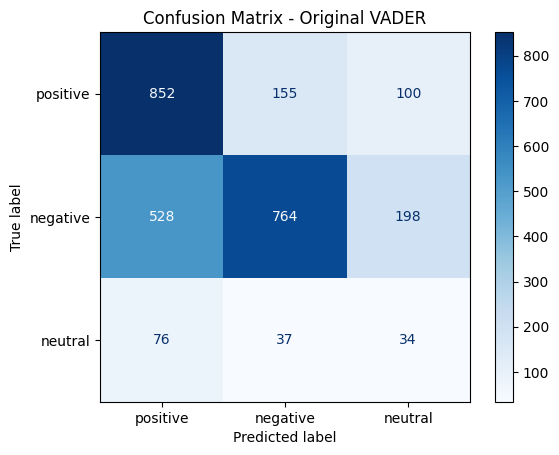

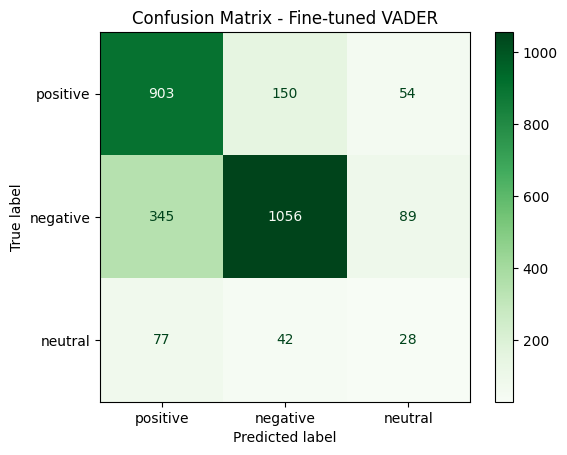

C:\Users\talk2\AppData\Local\Temp\ipykernel_54912\2898654074.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=accuracy_df, x="VADER Model", y="Accuracy (%)", palette="viridis")


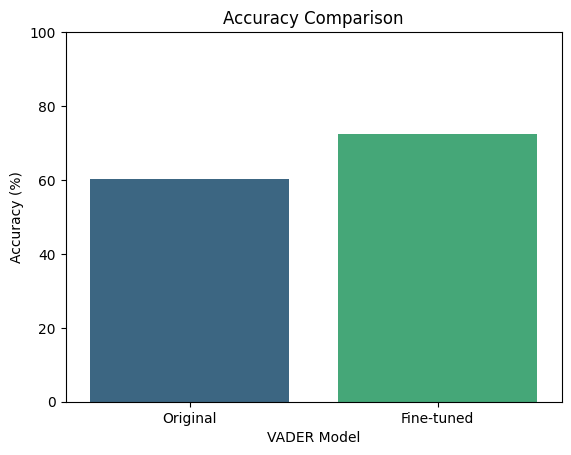

Classification Report - Original VADER
              precision    recall  f1-score   support

    positive       0.80      0.51      0.62      1490
    negative       0.10      0.23      0.14       147
     neutral       0.59      0.77      0.66      1107

    accuracy                           0.60      2744
   macro avg       0.50      0.50      0.48      2744
weighted avg       0.68      0.60      0.62      2744


Classification Report - Fine-tuned VADER
              precision    recall  f1-score   support

    positive       0.85      0.71      0.77      1490
    negative       0.16      0.19      0.18       147
     neutral       0.68      0.82      0.74      1107

    accuracy                           0.72      2744
   macro avg       0.56      0.57      0.56      2744
weighted avg       0.74      0.72      0.73      2744



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load the CSV file
file_path = "base_data_full.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Initialize the VADER sentiment analyzer
analyzer_original = SentimentIntensityAnalyzer()  # Original VADER
analyzer_finetuned = SentimentIntensityAnalyzer()  # Fine-tuned VADER

# Define a mapping from sentiment to scores for VADER
sentiment_map = {
    "positive": 2.0,
    "negative": -2.0,
    "neutral": 0.0
}

# Fine-tune the lexicon by updating it with the custom words
for _, row in data.iterrows():
    word = row["word"]
    sentiment = row["sentiment"].lower()
    if sentiment in sentiment_map:
        analyzer_finetuned.lexicon[word] = sentiment_map[sentiment]

# Function to predict sentiment based on VADER compound score
def predict_sentiment(compound_score):
    if compound_score >= 0.05:
        return "positive"
    elif compound_score <= -0.05:
        return "negative"
    else:
        return "neutral"

# Evaluate accuracy and collect predictions for visualizations
true_labels = []
original_predictions = []
finetuned_predictions = []

for _, row in data.iterrows():
    sentence = row["sentence"]
    true_sentiment = row["sentiment"].lower()
    true_labels.append(true_sentiment)
    
    # Original VADER prediction
    scores_original = analyzer_original.polarity_scores(sentence)
    predicted_original = predict_sentiment(scores_original["compound"])
    original_predictions.append(predicted_original)
    
    # Fine-tuned VADER prediction
    scores_finetuned = analyzer_finetuned.polarity_scores(sentence)
    predicted_finetuned = predict_sentiment(scores_finetuned["compound"])
    finetuned_predictions.append(predicted_finetuned)

# Calculate accuracy
accuracy_original = (sum([1 for t, p in zip(true_labels, original_predictions) if t == p]) / len(data)) * 100
accuracy_finetuned = (sum([1 for t, p in zip(true_labels, finetuned_predictions) if t == p]) / len(data)) * 100

# Print results
print(f"Accuracy of Original VADER: {accuracy_original:.2f}%")
print(f"Accuracy of Fine-tuned VADER: {accuracy_finetuned:.2f}%")

# Confusion Matrix for Original VADER
cm_original = confusion_matrix(true_labels, original_predictions, labels=["positive", "negative", "neutral"])
disp_original = ConfusionMatrixDisplay(confusion_matrix=cm_original, display_labels=["positive", "negative", "neutral"])
disp_original.plot(cmap='Blues')
plt.title("Confusion Matrix - Original VADER")
plt.show()

# Confusion Matrix for Fine-tuned VADER
cm_finetuned = confusion_matrix(true_labels, finetuned_predictions, labels=["positive", "negative", "neutral"])
disp_finetuned = ConfusionMatrixDisplay(confusion_matrix=cm_finetuned, display_labels=["positive", "negative", "neutral"])
disp_finetuned.plot(cmap='Greens')
plt.title("Confusion Matrix - Fine-tuned VADER")
plt.show()

# Accuracy Bar Chart
accuracy_data = {
    "VADER Model": ["Original", "Fine-tuned"],
    "Accuracy (%)": [accuracy_original, accuracy_finetuned]
}
accuracy_df = pd.DataFrame(accuracy_data)

sns.barplot(data=accuracy_df, x="VADER Model", y="Accuracy (%)", palette="viridis")
plt.title("Accuracy Comparison")
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.xlabel("VADER Model")
plt.show()

# Classification Report
print("Classification Report - Original VADER")
print(classification_report(true_labels, original_predictions, target_names=["positive", "negative", "neutral"]))

print("\nClassification Report - Fine-tuned VADER")
print(classification_report(true_labels, finetuned_predictions, target_names=["positive", "negative", "neutral"]))


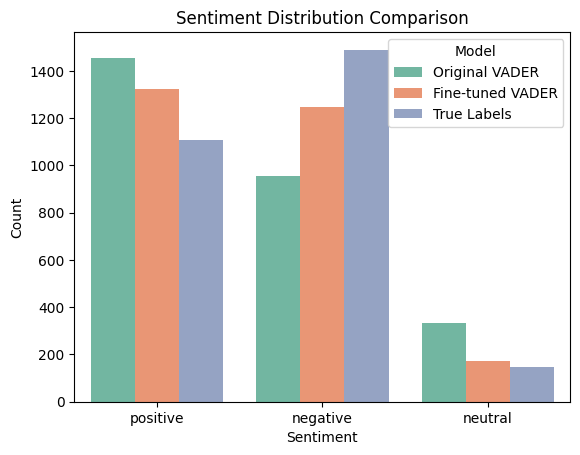

In [2]:
# Sentiment Distribution Comparison
sentiments = ["positive", "negative", "neutral"]

# Count occurrences for each sentiment in predictions
original_counts = [original_predictions.count(sentiment) for sentiment in sentiments]
finetuned_counts = [finetuned_predictions.count(sentiment) for sentiment in sentiments]
true_counts = [true_labels.count(sentiment) for sentiment in sentiments]

# Create a DataFrame for plotting
distribution_data = pd.DataFrame({
    "Sentiment": sentiments,
    "Original VADER": original_counts,
    "Fine-tuned VADER": finetuned_counts,
    "True Labels": true_counts
})

distribution_data = distribution_data.melt(id_vars="Sentiment", 
                                           var_name="Model", 
                                           value_name="Count")

sns.barplot(data=distribution_data, x="Sentiment", y="Count", hue="Model", palette="Set2")
plt.title("Sentiment Distribution Comparison")
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.legend(title="Model", loc="upper right")
plt.show()

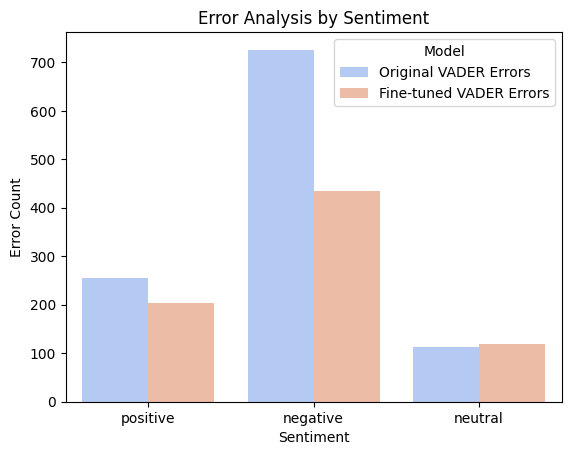

In [3]:
# Identify incorrect predictions for each model
incorrect_original = [true != pred for true, pred in zip(true_labels, original_predictions)]
incorrect_finetuned = [true != pred for true, pred in zip(true_labels, finetuned_predictions)]

# Count incorrect predictions by sentiment
errors_original = {sentiment: 0 for sentiment in sentiments}
errors_finetuned = {sentiment: 0 for sentiment in sentiments}

for i, true_sentiment in enumerate(true_labels):
    if incorrect_original[i]:
        errors_original[true_sentiment] += 1
    if incorrect_finetuned[i]:
        errors_finetuned[true_sentiment] += 1

# Create DataFrame for plotting
error_data = pd.DataFrame({
    "Sentiment": sentiments,
    "Original VADER Errors": [errors_original[s] for s in sentiments],
    "Fine-tuned VADER Errors": [errors_finetuned[s] for s in sentiments]
})

error_data = error_data.melt(id_vars="Sentiment", 
                             var_name="Model", 
                             value_name="Error Count")

sns.barplot(data=error_data, x="Sentiment", y="Error Count", hue="Model", palette="coolwarm")
plt.title("Error Analysis by Sentiment")
plt.ylabel("Error Count")
plt.xlabel("Sentiment")
plt.legend(title="Model", loc="upper right")
plt.show()


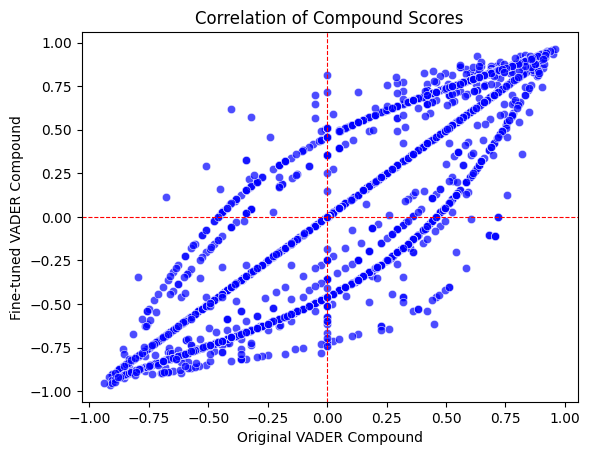

In [4]:
# Collect compound scores
original_scores = [analyzer_original.polarity_scores(sentence)["compound"] for sentence in data["sentence"]]
finetuned_scores = [analyzer_finetuned.polarity_scores(sentence)["compound"] for sentence in data["sentence"]]

# Create a DataFrame for plotting
correlation_data = pd.DataFrame({
    "Original VADER Compound": original_scores,
    "Fine-tuned VADER Compound": finetuned_scores
})

sns.scatterplot(data=correlation_data, x="Original VADER Compound", y="Fine-tuned VADER Compound", alpha=0.7, color="blue")
plt.title("Correlation of Compound Scores")
plt.xlabel("Original VADER Compound")
plt.ylabel("Fine-tuned VADER Compound")
plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.axvline(0, color='red', linestyle='--', linewidth=0.8)
plt.show()


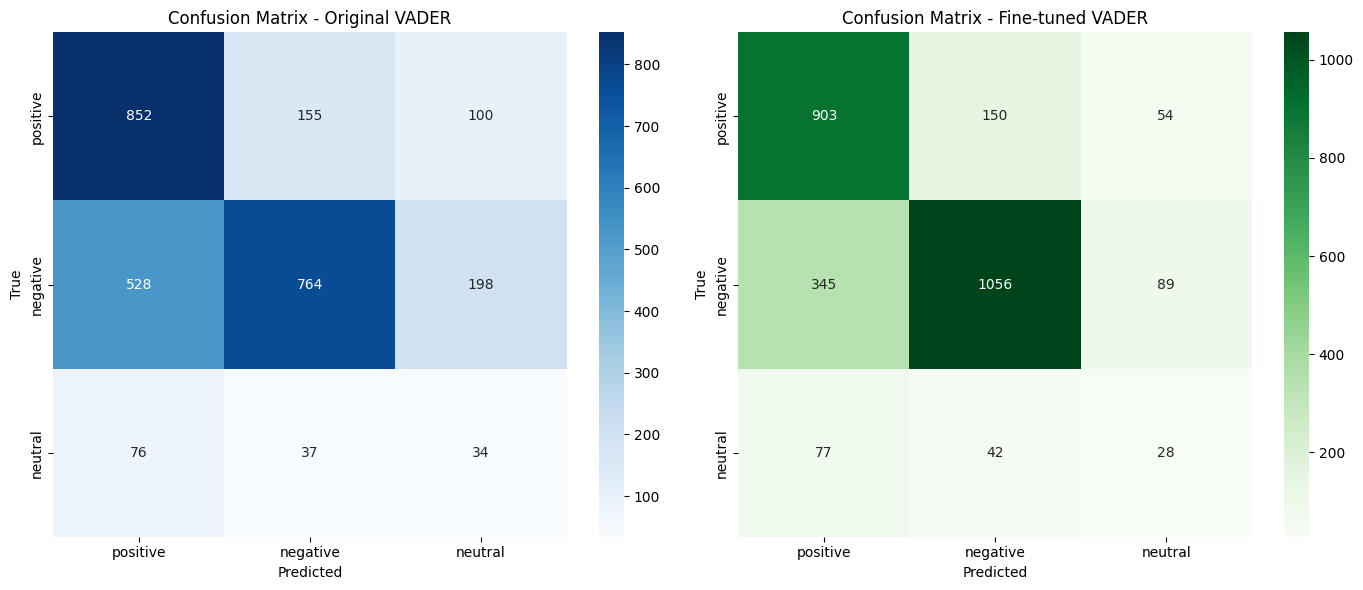

In [5]:
# Combine confusion matrices into a single plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_original, annot=True, fmt="d", cmap="Blues", ax=axes[0],
            xticklabels=sentiments, yticklabels=sentiments)
axes[0].set_title("Confusion Matrix - Original VADER")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_finetuned, annot=True, fmt="d", cmap="Greens", ax=axes[1],
            xticklabels=sentiments, yticklabels=sentiments)
axes[1].set_title("Confusion Matrix - Fine-tuned VADER")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

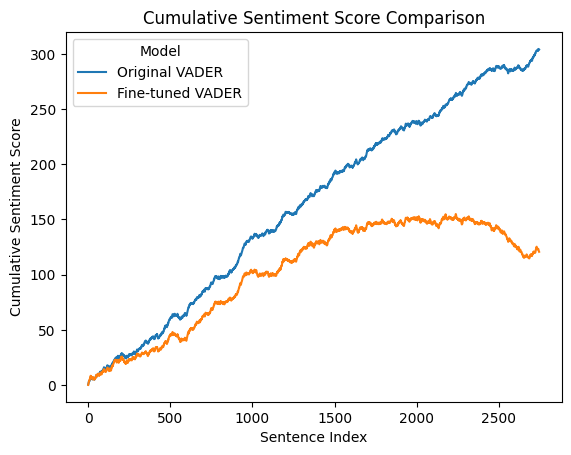

In [6]:
# Calculate cumulative sentiment scores
cumulative_original = pd.Series(original_scores).cumsum()
cumulative_finetuned = pd.Series(finetuned_scores).cumsum()

# Create DataFrame for plotting
cumulative_data = pd.DataFrame({
    "Sentence Index": range(1, len(data) + 1),
    "Original VADER": cumulative_original,
    "Fine-tuned VADER": cumulative_finetuned
}).melt(id_vars="Sentence Index", 
        var_name="Model", 
        value_name="Cumulative Score")

sns.lineplot(data=cumulative_data, x="Sentence Index", y="Cumulative Score", hue="Model", palette="tab10")
plt.title("Cumulative Sentiment Score Comparison")
plt.xlabel("Sentence Index")
plt.ylabel("Cumulative Sentiment Score")
plt.show()

In [8]:
# Lists to store examples for each case
original_better = []
finetuned_better = []
both_good = []
both_bad = []

# Iterate over each sentence in the data
for _, row in data.iterrows():
    sentence = row["sentence"]
    true_sentiment = row["sentiment"].lower()
    
    # Predictions by both models
    scores_original = analyzer_original.polarity_scores(sentence)
    predicted_original = predict_sentiment(scores_original["compound"])
    
    scores_finetuned = analyzer_finetuned.polarity_scores(sentence)
    predicted_finetuned = predict_sentiment(scores_finetuned["compound"])
    
    # Classify the examples into the four cases
    if predicted_original == true_sentiment and predicted_finetuned != true_sentiment:
        original_better.append((sentence, true_sentiment, predicted_original, predicted_finetuned))
    elif predicted_finetuned == true_sentiment and predicted_original != true_sentiment:
        finetuned_better.append((sentence, true_sentiment, predicted_original, predicted_finetuned))
    elif predicted_original == true_sentiment and predicted_finetuned == true_sentiment:
        both_good.append((sentence, true_sentiment, predicted_original, predicted_finetuned))
    elif predicted_original != true_sentiment and predicted_finetuned != true_sentiment:
        both_bad.append((sentence, true_sentiment, predicted_original, predicted_finetuned))

# Display examples
print("Examples where Original VADER performs better:")
for example in original_better[:1]:  # Show only the first 5 examples
    print(f"Sentence: {example[0]}\nTrue Sentiment: {example[1]}\nOriginal Prediction: {example[2]}\nFine-tuned Prediction: {example[3]}\n")

print("Examples where Fine-tuned VADER performs better:")
for example in finetuned_better[:1]:
    print(f"Sentence: {example[0]}\nTrue Sentiment: {example[1]}\nOriginal Prediction: {example[2]}\nFine-tuned Prediction: {example[3]}\n")

print("Examples where Both VADER models perform well:")
for example in both_good[:1]:
    print(f"Sentence: {example[0]}\nTrue Sentiment: {example[1]}\nOriginal Prediction: {example[2]}\nFine-tuned Prediction: {example[3]}\n")

print("Examples where Both VADER models perform poorly:")
for example in both_bad[:1]:
    print(f"Sentence: {example[0]}\nTrue Sentiment: {example[1]}\nOriginal Prediction: {example[2]}\nFine-tuned Prediction: {example[3]}\n")


Examples where Original VADER performs better:
Sentence: Despite market volatility, investors sought refuge in the perceived stability of stablecoins, hoping to avoid significant losses.
True Sentiment: negative
Original Prediction: negative
Fine-tuned Prediction: positive

Examples where Fine-tuned VADER performs better:
Sentence: Despite the hefty tuition,  our daughter thrives in the personalized attention of her microschool.
True Sentiment: positive
Original Prediction: neutral
Fine-tuned Prediction: positive

Examples where Both VADER models perform well:
Sentence: My new phone's cx is unbelievably smooth;  scrolling through endless cat videos is now a pure joy.
True Sentiment: positive
Original Prediction: positive
Fine-tuned Prediction: positive

Examples where Both VADER models perform poorly:
Sentence: Our company's recent foray into platform engineering has streamlined deployments, resulting in significantly faster release cycles.
True Sentiment: positive
Original Prediction:

In [255]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load the test dataset
test_file_path = "./the-reddit-dataset-dataset-comments.csv"  # Replace with your test file path
test_data = pd.read_csv(test_file_path)

# Map test sentiment scores to categories
def map_sentiment_to_category(sentiment_score):
    if sentiment_score >= 0.05:
        return "positive"
    elif sentiment_score <= -0.05:
        return "negative"
    else:
        return "neutral"

# Prepare the expected labels in the test data
test_data["expected_category"] = test_data["sentiment"].apply(map_sentiment_to_category)

# Function to predict sentiment based on VADER compound score
def predict_sentiment(compound_score):
    if compound_score >= 0.05:
        return "positive"
    elif compound_score <= -0.05:
        return "negative"
    else:
        return "neutral"

# Evaluate accuracy for both original and fine-tuned VADER
correct_original = 0
correct_finetuned = 0

for _, row in test_data.iterrows():
    sentence = str(row["body"])
    true_sentiment = row["expected_category"]
    
    # Original VADER prediction
    scores_original = analyzer_original.polarity_scores(sentence)
    predicted_original = predict_sentiment(scores_original["compound"])
    if predicted_original == true_sentiment:
        correct_original += 1
    
    # Fine-tuned VADER prediction
    scores_finetuned = analyzer_finetuned.polarity_scores(sentence)
    predicted_finetuned = predict_sentiment(scores_finetuned["compound"])
    if predicted_finetuned == true_sentiment:
        correct_finetuned += 1

# Calculate accuracy
total_sentences = len(test_data)
accuracy_original = (correct_original / total_sentences) * 100
accuracy_finetuned = (correct_finetuned / total_sentences) * 100

# Print results
print(f"Accuracy of Original VADER on Test Data: {accuracy_original:.2f}%")
print(f"Accuracy of Fine-tuned VADER on Test Data: {accuracy_finetuned:.2f}%")


Accuracy of Original VADER on Test Data: 97.07%
Accuracy of Fine-tuned VADER on Test Data: 94.01%
